## Importing Libraries and Data

In [1]:
## Importing libraries and dependencies
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The following data set is found at https://screeningtool.geoplatform.gov/en/downloads#3/33.47/-97.5 


This data is the straight from the federal government's Climate and Economic Justice Screening Tool. 


Please refer to the codebooks and guides found in the aforementioned link above for more information about the collection of data, how they're organized, and information about individiual datasets and their features.

In [2]:
## Importing CEJST shapefile. If you were to go on CEJST site the files are labeled as 'usa.shp', etc.
data = gpd.read_file('cejst.shp')

## Filtering data for Georgia (SF column = State)
ga = data[data['SF'] == 'Georgia']

## CEJST Methodology 

One of the most important columns in the CEJST dataset is 'SN_C', which is a binary indicator indicating whether a census tract is environmentally disadvantaged or not disadvantaged. 

Below produces a map that shows census tracts in GA that are environmentally disadvantaged (SN_C) according to definition N:  Water, Workforce, Climate, Energy, Transportation, Housing, Pollution, Health.  

These definition N burdens are assessed based on exceeding a given sub-metric in the dataset (e.g. expected agriculture rate, asthma prevalency, historic underinvestment, etc). Additionally, a census tract must fulfill a low-income threshold to be classified as a 1 (burdened).  The government uses the low-income clause as a proxy for race and thus do not explicitly include race in their classification.  

To summarize, a census tract is burdened in any one of the definition N categories if it exceeds a sub-metric threshold and low-income status.  

The CEJST's classification, which is binary (0 or 1), reflects if a census tract is burdened in any one of the definition N areas. 

Thus, we are somewhat unable to analyze if a geography faces multiple significant burdens.  We want to advance this map to allow for more nuanced and a continuous classification.  Note, we also want to include race as an explicit predictor for our index, which the CEJST does not (as it uses low income as a proxy).

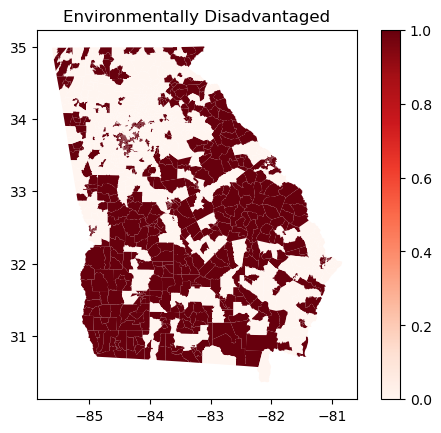

In [3]:
ga.plot(column = 'SN_C', legend = True, cmap = 'Reds')
plt.title('Environmentally Disadvantaged')
plt.show()

## Some quick data manipulation before index construction...

Below I make a column of min-max normalized total population to be included in index (as areas with more people should probably get more attention)

In [4]:
## Creating column for Min-Max scaled total population 

ga['norm_TPF'] = (ga['TPF'] - ga['TPF'].min()) / (ga['TPF'].max() - ga['TPF'].min())

/Users/jacoblapp/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Below, I create a new column for a tract's nonwhite percentage: DM_NW. This will be int64 ranging from 0-1.  I then plot nonwhite percentagers across the state of Georgia to build an intuition of demographics. We see large nonwhite populations in Atlanta, the Black Belt (including Augusta, AMcon, and Columbus), and Southeast Georgia (Savannah, Brunswick).

/Users/jacoblapp/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


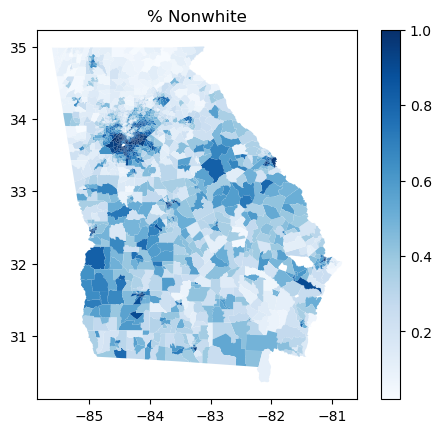

In [5]:
ga['DM_NW'] = 1- ga['DM_W'] # DM_W is % white
ga.plot(column = 'DM_NW', legend = True, cmap = 'Blues')
plt.title('% Nonwhite')
plt.show()

## Identifying columms that should be the foundational components of the Georgia specific EJ index. 

Below are the columns of the shp CEJST file that will be the primary components of the index. 

They are the 8 definition CEJST burdens: water, climate, energy, transportation, housing, health, pollution, and workforce. These burdens are all binary classifications based on whether they meet their burdens and satisfy a low income requirement as defined by the CEJST. 

However, we make two changes for our index.  We exclude the CEJST's definition of workforce burden because it does not include many demographic measures.  Instead of their workforce burden classifcation, we replace it with the mean of a tract's linguistic isolation population, low median household income, and high school education attainment, and unemployment. The resulting column will also range from 0 to 1, but will be a continuous classificaion. This new mean workforce development indicator is titled 'wk'

Lastly, and importantly, we directly use the nonwhite percentage column defined above as a direct component of the index, entitled 'DM_NW'.  We also include the normalized tract population from earlier.

The index itself is the sum of all of these columns.

Now, while the summed index is how we approached this problem, further work should investigate the influence individual sub-metrics (diesel particulate, air quality, all of the micro columns that determine the 0s and 1s).  Our approach was to start our index from the CEJST's 0s and 1s groupings (except for workforce), but if we grouped these burdens on a smaller level we could get different results.  Comparing index values across different grouping methods will give insight into our index's accuracy and consistency.

In [12]:
our_workforce_columns = ['LIF_PFS', 'LMI_PFS', 'HSEF', 'UF_PFS']
ga['wk'] = ga[our_workforce_columns].mean(axis = 1)

index_columns = ['DM_NW', 'norm_TPF', 'N_WTR', 'N_CLT', 'N_ENY', 'N_TRN', 'N_HSG', 'N_PLN', 'N_HLTH', 'wk']
additional_columns = ['GEOID10', 'SF', 'CF', 'ga_idx']

ga['ga_idx'] = np.sum(ga[index_columns], axis =1) # sum of index columns = index

/Users/jacoblapp/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/jacoblapp/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Below is a sliced dataƒrame of the Georgia CEJST to show the columns we care about for the index:

In [7]:
idx_summary = ga[additional_columns + index_columns]
idx_summary

,GEOID10,SF,CF,ga_idx,DM_NW,norm_TPF,N_WTR,N_CLT,N_ENY,N_TRN,N_HSG,N_PLN,N_HLTH,wk
18332,13135050709,Georgia,Gwinnett County,1.777250,0.80,0.517250,0,0,0,0,0,0,0,0.4600
18333,13135050314,Georgia,Gwinnett County,1.632987,0.80,0.362987,0,0,0,0,0,0,0,0.4700
18334,13135050315,Georgia,Gwinnett County,1.445268,0.72,0.237768,0,0,0,0,0,0,0,0.4875
18335,13135050415,Georgia,Gwinnett County,1.024707,0.58,0.152207,0,0,0,0,0,0,0,0.2925
18336,13135050425,Georgia,Gwinnett County,0.954023,0.46,0.209023,0,0,0,0,0,0,0,0.2850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20296,13153020105,Georgia,Houston County,1.183742,0.54,0.218742,0,0,0,0,0,0,0,0.4250
20297,13153020106,Georgia,Houston County,0.740818,0.35,0.083318,0,0,0,0,0,0,0,0.3075
20298,13153020108,Georgia,Houston County,1.053564,0.38,0.223564,0,0,0,0,0,0,0,0.4500
20299,13153020109,Georgia,Houston County,1.075692,0.48,0.330692,0,0,0,0,0,0,0,0.2650


The index is created as a new column and is calculated by summing the columns defined in the previous cell.

## Plotting and Analyzing Georgia-specific EJ Index

Here is a map of our Georgia EJ index.  The darker values correspond with higher values, meaning that the geography faces more burdens.  We see that similar areas (SW ATL, Columbus, Augusta, Macon, Black Belt, SW & SE GA) have high index scores and higher nonwhite populations (comparing from the earlier NW map)

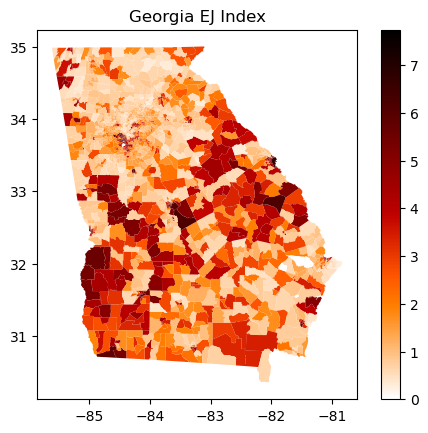

In [8]:
ga.plot(column = 'ga_idx', legend = True, cmap = 'gist_heat_r')
plt.title('Georgia EJ Index')
plt.show()

Here are the ten census tracts that face the most environmental burden according to our index:

In [9]:
idx_summary.rename(columns = {'GEOID10' : 'Tract ID', 'SF' : 'State', 'CF' : 'County', 'ga_idx' : 'GA EJ Index'}, inplace = True)
idx_summary.sort_values(by = 'GA EJ Index', ascending = False).head(10).iloc[:,0:4]

/var/folders/rb/wdj9db193s70npfrcghpqt340000gn/T/ipykernel_1359/2148117855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_summary.rename(columns = {'GEOID10' : 'Tract ID', 'SF' : 'State', 'CF' : 'County', 'ga_idx' : 'GA EJ Index'}, inplace = True)


,Tract ID,State,County,GA EJ Index
19706,13051001200,Georgia,Chatham County,7.740723
19761,13121007603,Georgia,Fulton County,7.723135
19762,13121007604,Georgia,Fulton County,7.711251
18983,13121011000,Georgia,Fulton County,6.835983
18553,13245010600,Georgia,Richmond County,6.750743
19293,13121004400,Georgia,Fulton County,6.740892
19295,13121007400,Georgia,Fulton County,6.732537
19251,13185011000,Georgia,Lowndes County,6.723643
20204,13095010601,Georgia,Dougherty County,6.663931
18924,13121007500,Georgia,Fulton County,6.605145


Here is the distrubtion of our index.  We see that there are lots of census tracts with low index values, and not many with high values.  This phenemona is good for us, as it enables us to easily identify a handful of census tracts in serious need.

Text(0, 0.5, 'Number of Census Tracts in Georgia')

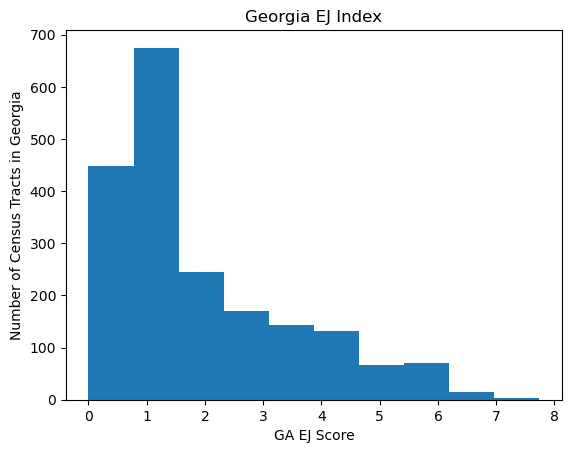

In [10]:
plt.hist(ga.ga_idx)
plt.title('Georgia EJ Index')
plt.xlabel('GA EJ Score')
plt.ylabel('Number of Census Tracts in Georgia')

Here is a quick plot showing the relationship between a census tract's nonwhite percentage and their index score.  Clearly, there is a positive relationship between the two, highlighting that nonwhite populations face higher environmental justice burdens.

[Text(0.5, 0, 'Percent Nonwhite'), Text(0, 0.5, 'GA EJ Index Score')]

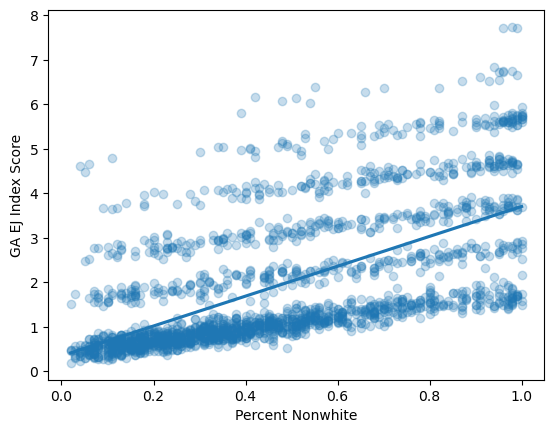

In [11]:
ax = sns.regplot(ga,
    x = 'DM_NW',
    y = 'ga_idx',
    scatter_kws={'alpha':0.25},
    ci = None)
ax.set(xlabel = 'Percent Nonwhite',
    ylabel = 'GA EJ Index Score')